In [1]:
import os
from typing import *
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
import torch.nn.functional as F
import xml.etree.ElementTree as ET

import albumentations as A

In [2]:
class CustomOxFordPet(Dataset):
    def __init__(self, root:str = "/media/mountHDD2/oxfordpet", split = 'trainval'):
        self.root = root
        self._split = split

        self.aug_transforms = A.Compose(
            [
                A.Resize(256, 256),
                A.HorizontalFlip(p=0.2),
                A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=3, p=0.5, border_mode = cv2.BORDER_CONSTANT),
            ]
        )

        self.img_transform = A.Compose(
            [
                A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
            ]
        )

        self._images_folder = self.root + "/images"
        self._anns_folder = self.root + "/annotations"
        self._segs_folder = self._anns_folder + "/trimaps"

        image_ids = []
        self._labels = []
        with open(self._anns_folder + f"/{self._split}.txt") as file:
            for line in file:
                image_id, label, *_ = line.strip().split()
                image_ids.append(image_id)
                self._labels.append(int(label) - 1)

        self.classes = [
            " ".join(part.title() for part in raw_cls.split("_"))
            for raw_cls, _ in sorted(
                {(image_id.rsplit("_", 1)[0], label) for image_id, label in zip(image_ids, self._labels)},
                key=lambda image_id_and_label: image_id_and_label[1],
            )
        ]
        self.class_to_idx = dict(zip(self.classes, range(len(self.classes))))

        self._images = [self._images_folder + f"/{image_id}.jpg" for image_id in image_ids]
        self._segs = [self._segs_folder + f"/{image_id}.png" for image_id in image_ids]

    @staticmethod
    def process_mask(x):
        uniques = torch.unique(x, sorted = True)
        if uniques.shape[0] > 3:
            x[x == 0] = uniques[2]
            uniques = torch.unique(x, sorted = True)
        print(uniques)
        for i, v in enumerate(uniques):
            x[x == v] = i
        
        x = x.to(dtype=torch.long)
        onehot = F.one_hot(x.squeeze(1), 3).permute(0, 3, 1, 2)[0].float()
        return onehot

    def __len__(self):
        return len(self._images)

    def __getitem__(self, idx):
        image = cv2.imread(self._images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        
        mask = cv2.imread(self._segs[idx])

        transformed = self.aug_transforms(image = image, mask = mask)
        transformed_img = self.img_transform(image=transformed["image"])["image"]
        transformed_mask = transformed["mask"]

        torch_img = torch.from_numpy(transformed_img).permute(-1, 0, 1).float()
        torch_mask = torch.from_numpy(transformed_mask).permute(-1, 0, 1).float()

        target = {
            "semantic" : self.process_mask(torch_mask),
            "category" : self._labels[idx],
        }

        return torch_img, target

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3680
3669
tensor([1., 2., 3.])
Image Shape/Dtype: torch.Size([3, 256, 256])/torch.float32
semantic Shape/Dtype: torch.Size([3, 256, 256])/torch.float32
category: 0
tensor([1., 2., 3.])
Image Shape/Dtype: torch.Size([3, 256, 256])/torch.float32
semantic Shape/Dtype: torch.Size([3, 256, 256])/torch.float32
category: 0
tensor([1., 2., 3.])
Image Shape/Dtype: torch.Size([3, 256, 256])/torch.float32
semantic Shape/Dtype: torch.Size([3, 256, 256])/torch.float32
category: 0
tensor([1., 2., 3.])
Image Shape/Dtype: torch.Size([3, 256, 256])/torch.float32
semantic Shape/Dtype: torch.Size([3, 256, 256])/torch.float32
category: 0
tensor([1., 2., 3.])
Image Shape/Dtype: torch.Size([3, 256, 256])/torch.float32
semantic Shape/Dtype: torch.Size([3, 256, 256])/torch.float32
category: 0


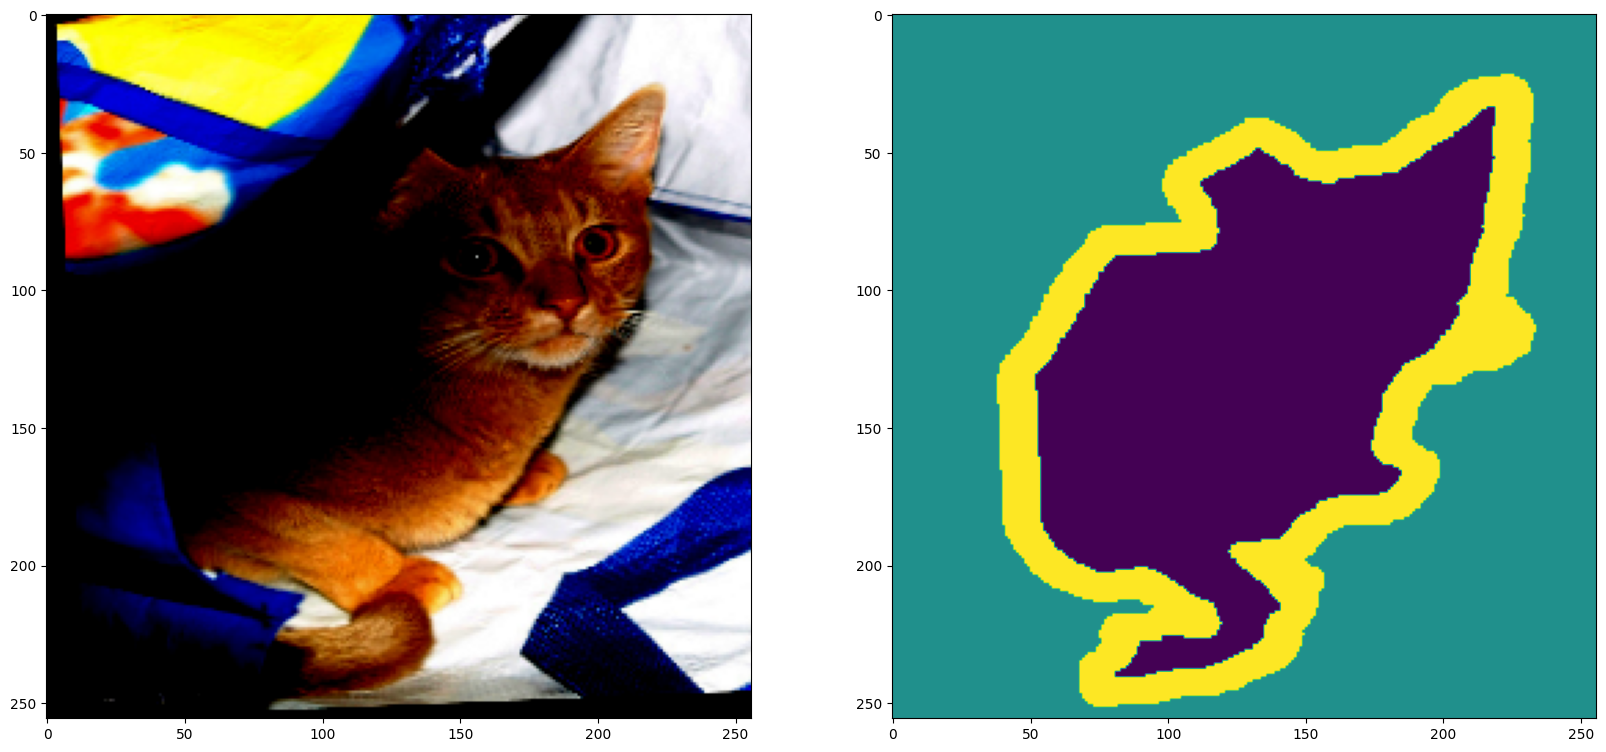

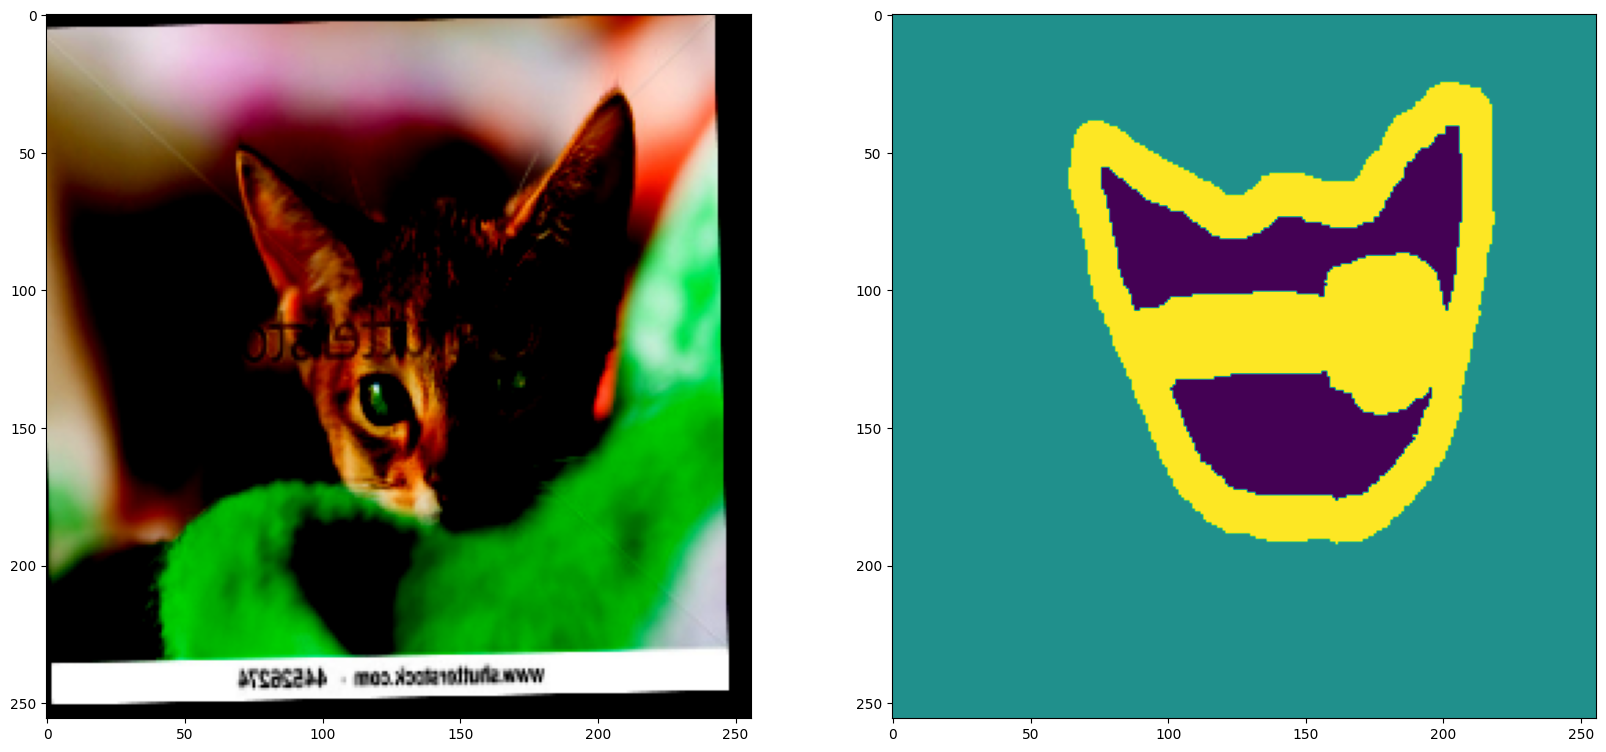

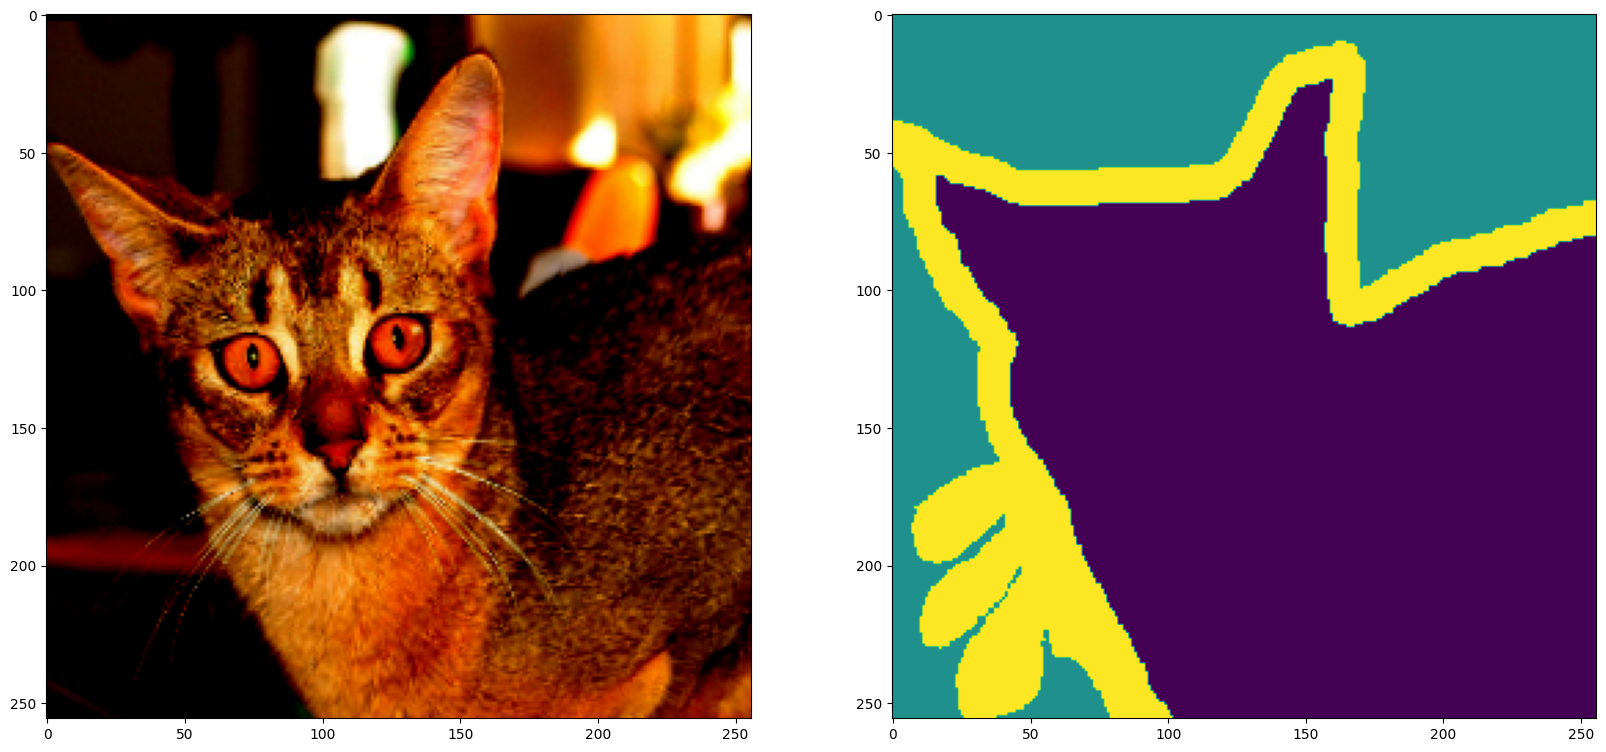

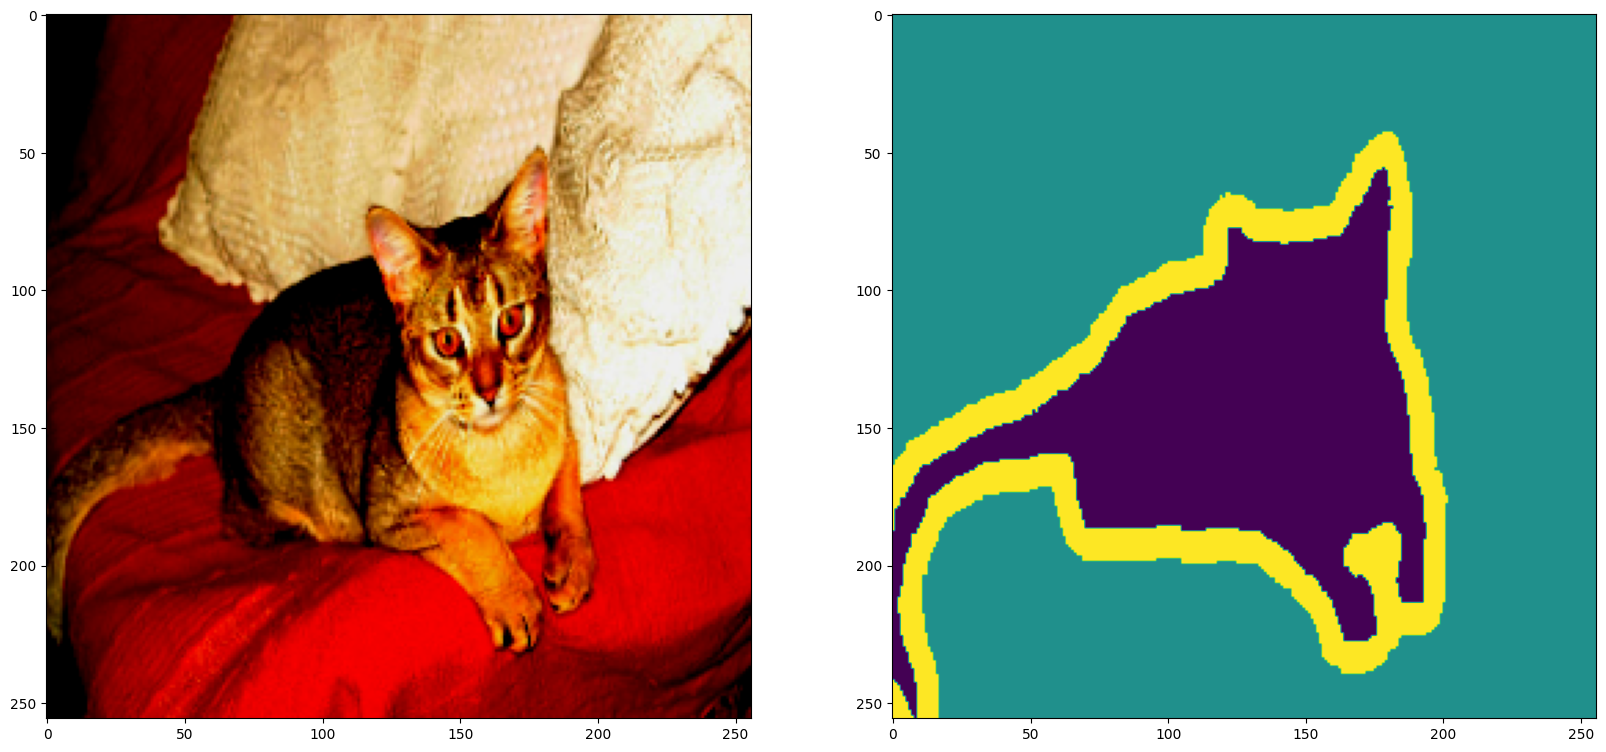

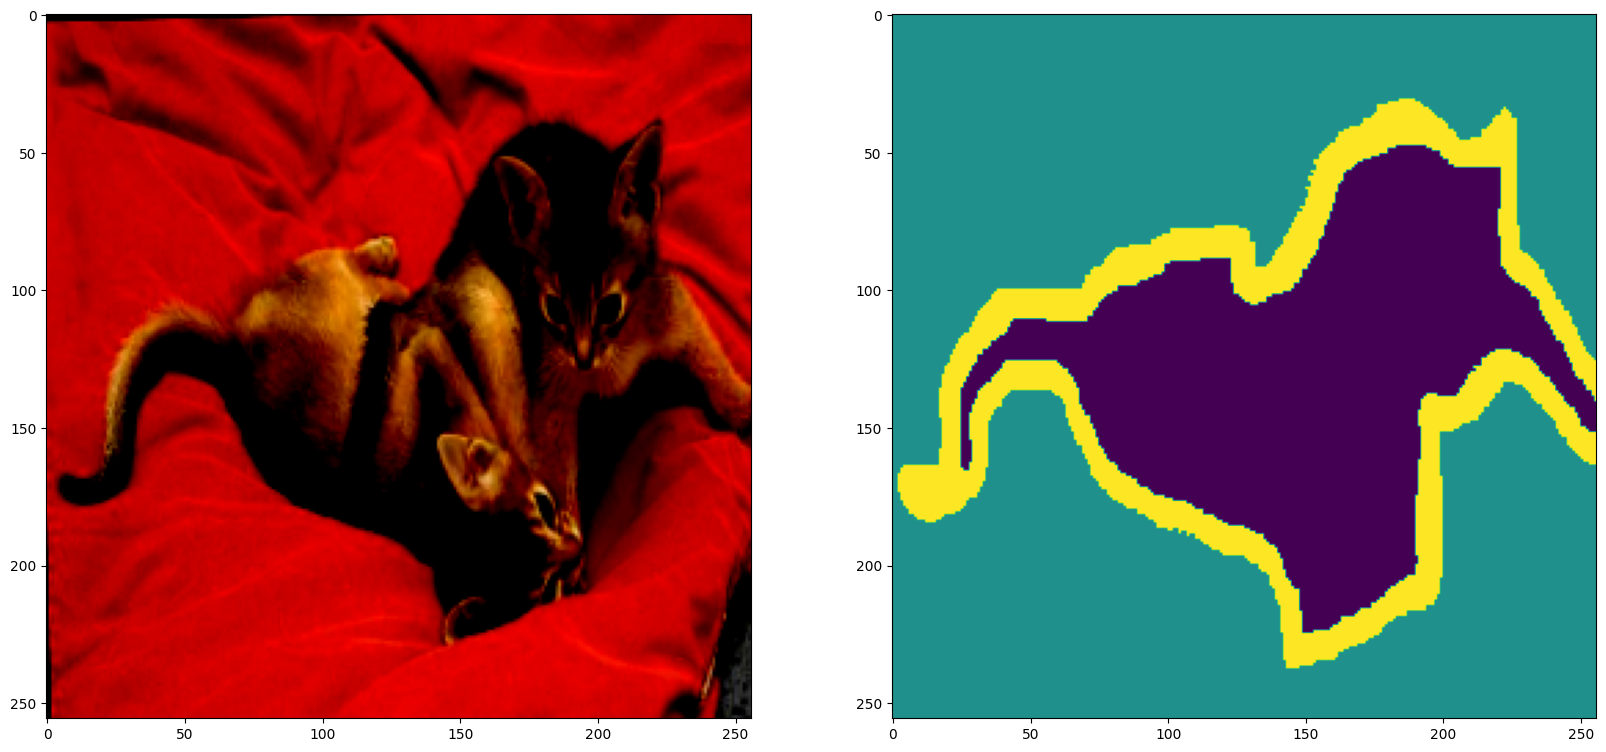

In [3]:
train_ds = CustomOxFordPet(split = 'trainval')
test_ds = CustomOxFordPet(split = 'test')

print(len(train_ds))
print(len(test_ds))

for idx in range(5):
    img, target = train_ds[idx]

    print(f"Image Shape/Dtype: {img.shape}/{img.dtype}")
    for key in target:
        if isinstance(target[key], int):
            print(f"{key}: {target[key]}")
        else:
            print(f"{key} Shape/Dtype: {target[key].shape}/{target[key].dtype}")

    img_np = img.permute(1, -1, 0).numpy()

    f, axarr = plt.subplots(1, 2, figsize=(20, 15))
    axarr[0].imshow(img_np)
    axarr[1].imshow(torch.argmax(target['semantic'], dim = 0).unsqueeze(0).permute(1, -1, 0).numpy())

In [4]:
extra_train_ds, valid_ds, test_ds = random_split(test_ds, [0.8, 0.1, 0.1])

train_ds = ConcatDataset([train_ds, extra_train_ds])

print(f"#Training Samples: {len(train_ds)}")
print(f"#Validating Samples: {len(valid_ds)}")
print(f"#Testing Samples: {len(test_ds)}")

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, pin_memory=True, num_workers=24)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=True, pin_memory=True, num_workers=24)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=True, pin_memory=True, num_workers=24)

print(f"Train Batch Samples: {len(train_dl)}")
print(f"Valid Batch Samples: {len(valid_dl)}")
print(f"Test Batch Samples: {len(test_dl)}")

#Training Samples: 6616
#Validating Samples: 367
#Testing Samples: 366
Train Batch Samples: 104
Valid Batch Samples: 6
Test Batch Samples: 6
